<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# GARCH models

---

## Learning Objectives
- Understand how effects of non-constant variance can be taken into account in GARCH models
- Fit GARCH models using the ARCH module

## Introduction

We started building models for time series assuming stationarity.

We modeled 

$$Y_t=f(y_{t-1},\ldots,y_{t-n})+\epsilon_t$$

as a function of the $n$ preceding data points assuming that

1. $$E(Y_t)=\mu$$

1. $$Var(Y_t)=\sigma^2$$

1. $${\rm cov}(Y_t,Y_s)=\gamma(|t-s|)$$

We were able to treat violation of the first condition by transformations of the original time series and differencing and to model time series with ARIMA models.

We learned how to modify ARIMA models to take into account seasonal effects.

#### What can we do if the variance does not remain constant?

Remember that the noise term $\epsilon_t$ was assumed to stem from a normal distribution with variance $\sigma^2$:

$$\epsilon_t\sim N(0,\sigma^2)=\sigma\, N(0,1)$$

Now we will make $\sigma$ time-dependent, too.
Then our noise will be the product of two terms:

$$\epsilon_t=e_t\sigma_t = e_t\sqrt{\omega+\alpha\, \epsilon_{t-1}^2}$$

Here, $\omega$ and $\alpha$ are positive constants chosen in such a way that the term under the square root remains positive. It is possible to show that for $\alpha<1$ the time series remains even stationary.

The consequence is that $a_t$ reacts to the preceding variance and will be smaller or larger accordingly. 

This is called an **ARCH(1)** process standing for Autoregressive Conditional Heteroskedasticity.

Combining an AR(1) process with an ARCH(1) process will allow to model timeseries with time dependent variance:

$$y_t=(1-\phi)\mu+\phi y_{t-1}+\epsilon_t$$

Generalizing to combinations with AR(p) models is straight-forward.

To build more complex models, one can formulate ARCH(p) models

$$\sigma_t = \sqrt{\omega+\sum_{i=1}^p\alpha_i \epsilon_{t-i}^2}$$

Characteristically, these models will lead to high frequency oscillations with high volatility in short bursts - after a short time the volatility will return to normal levels. 

To model more realistic scenarios, one would like to have models which show changes in volatility with a longer time persistance. 

This can be achieved by creating a feedback on past values of the variance of the time series with GARCH(p,q) models:


$$\sigma_t=\sqrt{\omega+\sum_{i=1}^{p}\alpha_i \epsilon_{t-i}^2+\sum_{j=1}^q\beta_j\sigma_{t-j}^2}$$

This can be combined with AR(p) to obtain an

${\rm AR}(p_M)+{\rm GARCH}(p_V,q_V)$ model.

## The ARCH package

We will use the [Arch package](https://arch.readthedocs.io/en/latest/index.html) to model GARCH processes. It allows to model a whole range of further models and has very nice tools for further analysis.

To illustrate how the model works, we will use again the Apple stock data and model price differences.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
 
plt.style.use('fivethirtyeight')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
df = pd.read_csv('datasets/aapl.csv')
df['Date'] = pd.to_datetime(df.Date)
df.sort_values(by='Date', inplace=True)
#df.reset_index(inplace=True)

df.set_index('Date', inplace=True, drop=True)
df.index.name = None
df.head()

,Open,High,Low,Close,Volume
2016-01-19,98.41,98.65,95.50,96.66,52841349
2016-01-20,95.10,98.19,93.42,96.79,72008265
2016-01-21,97.06,97.88,94.94,96.30,52054521
2016-01-22,98.63,101.46,98.37,101.42,65562769
2016-01-25,101.52,101.53,99.21,99.44,51196375


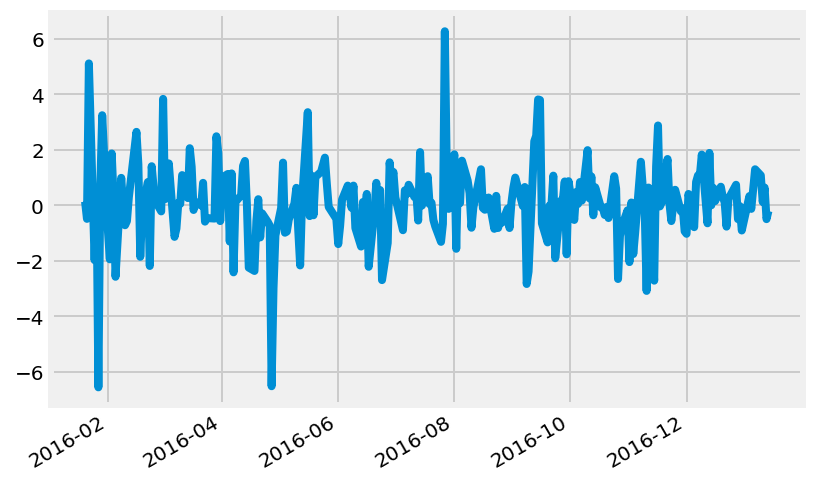

In [3]:
df.Close.diff().plot();

In [4]:
data = df.Close.diff()[1:]

## Fitting an AR(p) model

In [5]:
from arch.univariate import ARX

In [6]:
ar = ARX(data, lags = 3, constant=True)
ar.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     AR - Constant Variance Model Results                     
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.015
Mean Model:                        AR   Adj. R-squared:                  0.003
Vol Model:          Constant Variance   Log-Likelihood:               -433.265
Distribution:                  Normal   AIC:                           876.530
Method:            Maximum Likelihood   BIC:                           894.077
                                        No. Observations:                  247
Date:                Fri, Aug 24 2018   Df Residuals:                      242
Time:                        08:44:24   Df Model:                            5
                                 Mean Model                                
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
Const          0.0701  8.973e-02      0.781      0.435    [ -0.106,  0.246]
Close[1]       0.0956  6.906e-02      1.384      0.166 [-3.979e-02,  0.231]
Close[2]      -0.0135  7.762e-02     -0.174      0.862    [ -0.166,  0.139]
Close[3]      -0.0703  8.940e-02     -0.787      0.431    [ -0.246,  0.105]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
sigma2         1.9549      0.313      6.251  4.079e-10 [  1.342,  2.568]
========================================================================

Covariance estimator: White's Heteroskedasticity Consistent Estimator
"""

## Fitting a Volatility Model

Below we set up the `arch_model`. Apart from our timeseries we specify

- `mean`:  This part is related to the AR part. Among the choices are `constant` or `AR`.
- `lags`: If we have chosen to model the mean through an AR process, here we can specify which lags to include (either specifying a single number or explicitly referring to a list of lags to include).
- `vol`: Here we specify our model for the time dependence of the volatility. We choose the default `GARCH`, but there are many more options.
- `p` and `q`: These parameters specify the order of the ARMA process modeling the volatility.

In [7]:
from arch import arch_model

In [8]:
am = arch_model(data, mean='AR', lags=3, vol='GARCH', p=3, q=3)
res = am.fit(update_freq=7)
res.summary()

Iteration:      7,   Func. Count:    103,   Neg. LLF: 426.12309930408946
Iteration:     14,   Func. Count:    199,   Neg. LLF: 424.3377295236413
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 424.327962233456
            Iterations: 19
            Function evaluations: 265
            Gradient evaluations: 19


<class 'statsmodels.iolib.summary.Summary'>
"""
                           AR - GARCH Model Results                           
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.010
Mean Model:                        AR   Adj. R-squared:                 -0.002
Vol Model:                      GARCH   Log-Likelihood:               -424.328
Distribution:                  Normal   AIC:                           870.656
Method:            Maximum Likelihood   BIC:                           909.259
                                        No. Observations:                  247
Date:                Fri, Aug 24 2018   Df Residuals:                      236
Time:                        08:44:24   Df Model:                           11
                                 Mean Model                                
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
Const          0.1332      0.119      1.121      0.262 [-9.963e-02,  0.366]
Close[1]       0.1395  7.368e-02      1.893  5.836e-02 [-4.934e-03,  0.284]
Close[2]   2.0460e-03  8.412e-02  2.432e-02      0.981    [ -0.163,  0.167]
Close[3]      -0.0510  8.634e-02     -0.590      0.555    [ -0.220,  0.118]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.6924      0.419      1.651  9.867e-02      [ -0.129,  1.514]
alpha[1]   4.8782e-03  2.417e-02      0.202      0.840 [-4.249e-02,5.224e-02]
alpha[2]       0.2273      0.309      0.737      0.461      [ -0.377,  0.832]
alpha[3]   8.1696e-13  6.662e-02  1.226e-11      1.000      [ -0.131,  0.131]
beta[1]        0.0000      0.199      0.000      1.000      [ -0.390,  0.390]
beta[2]        0.1281  7.407e-02      1.729  8.374e-02   [-1.708e-02,  0.273]
beta[3]        0.2788      0.261      1.067      0.286      [ -0.233,  0.791]
=============================================================================

Covariance estimator: robust
"""

## Model score and residuals

We can directly obtain the R-squared score (related to one-step ahead forecasts).

In [9]:
res.rsquared

0.009744625251647543

We can extract the standardized residuals, the conditional volatility and their product, the residuals.

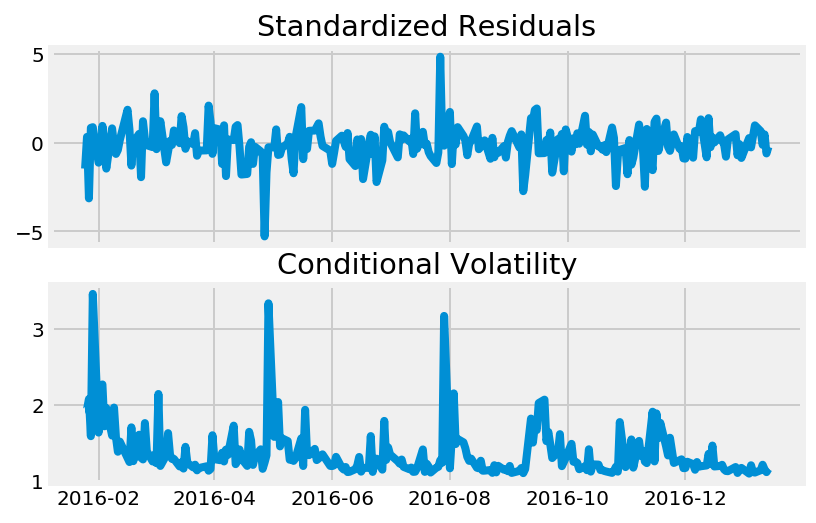

In [10]:
res.plot();

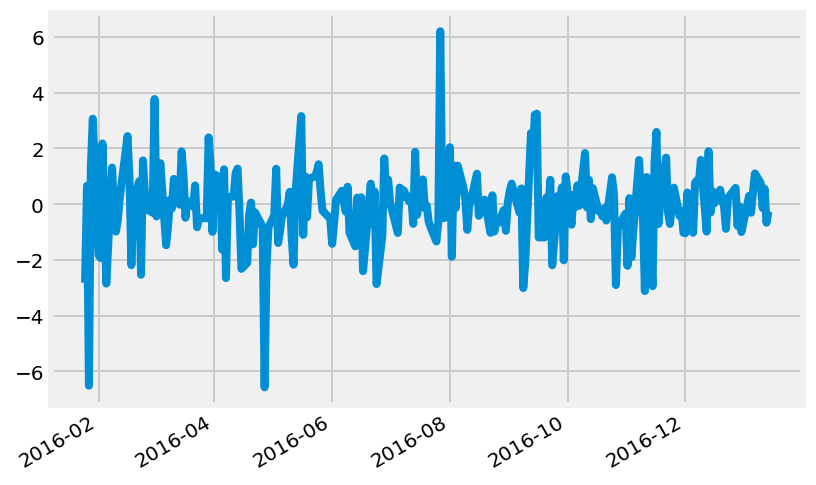

In [11]:
res.resid.plot();

The standardized residuals are obtained in that way:

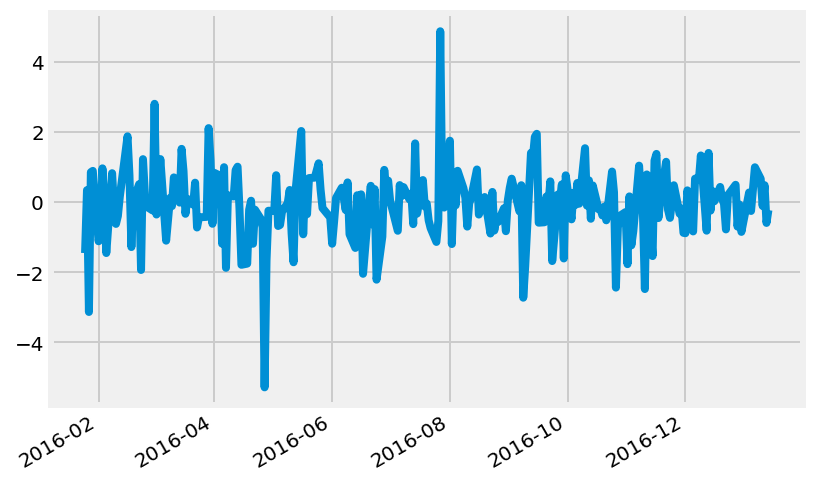

In [12]:
resid_standardized = (res.resid/res.conditional_volatility)
resid_standardized.plot();

The standardized residuals have to meet the requirements of normality and independence, not so the conditional volatility however.

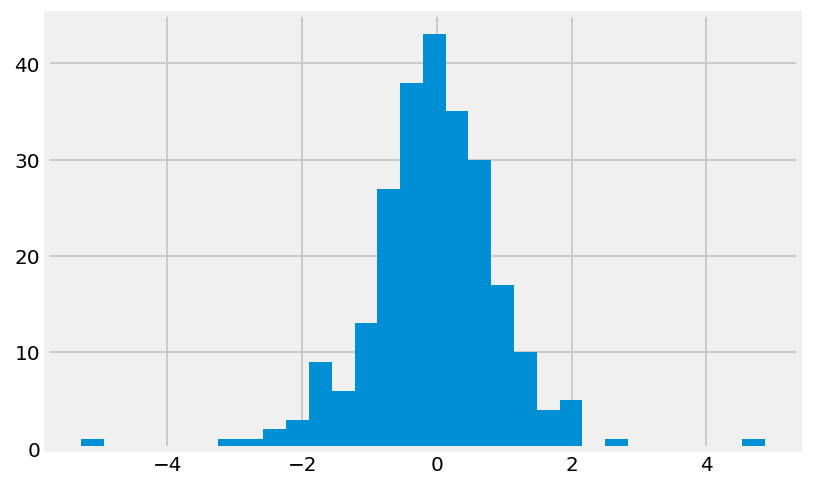

In [13]:
resid_standardized.hist(bins=30);

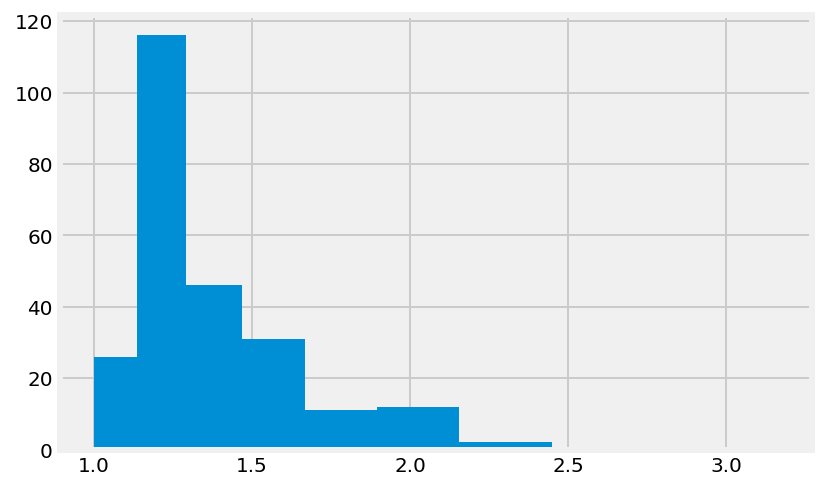

In [14]:
res.conditional_volatility.hist(bins=np.logspace(0,0.5,10));

## Forecasts

The Arch package has very nice forecasting functionality. After having called the forecast function we can extract several results. The two arguments are

- `horizon`: Indicating an integer $n$, we will obtain $n$-step ahead forecasts for after the indicated date.
- `start`: This is the start date from which on we are making forecasts (there is a lower limit according to your model degree - Arch will kindly inform you about that in case).

From the forecast object, we can extract the predictions for the 

- `mean`: These are our time series values. The predictions are not different from the AR(p) model predictions.
- `conditional_volatility`: These predictions are made by our GARCH model to estimate the expected volatility for each date.
- `residual_variance`: The predicted variance of the residuals.

In [15]:
forecasts = res.forecast(horizon=5, start=2)

In [16]:
forecasts.mean[:15]

,h.1,h.2,h.3,h.4,h.5
2016-01-20,NaN,NaN,NaN,NaN,NaN
2016-01-21,NaN,NaN,NaN,NaN,NaN
2016-01-22,0.839661,0.285767,-0.086147,0.078991,0.129490
2016-01-25,-0.107486,-0.146762,0.213433,0.168158,0.164582
2016-01-26,-0.055064,0.227567,0.136809,0.155565,0.143592
2016-01-27,-0.681058,-0.003245,0.466198,0.232935,0.166819
2016-01-28,0.185185,0.495242,0.168517,0.148291,0.129001
2016-01-29,0.922685,0.234402,0.002161,0.086971,0.133401
2016-02-01,-0.021199,-0.037237,0.174353,0.158534,0.157578
2016-02-02,-0.306243,0.132889,0.250499,0.184029,0.152619


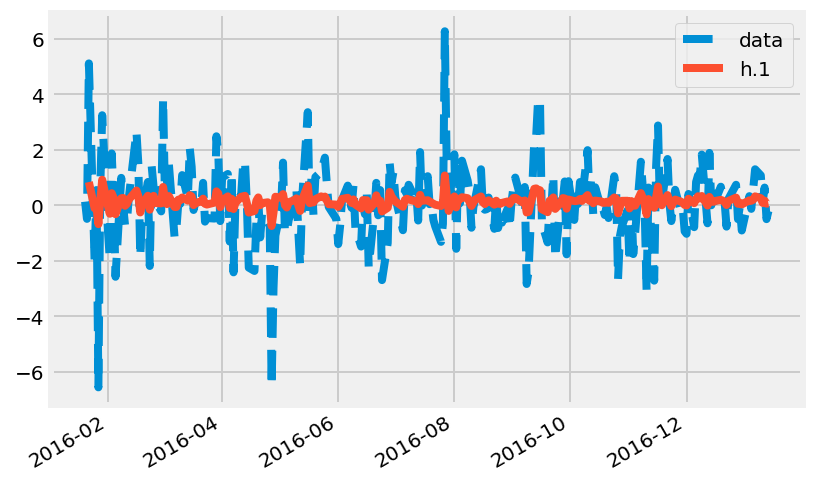

In [17]:
fig, ax = plt.subplots()
data.plot(ax=ax,label='data',ls='--')
forecasts.mean[['h.1']].plot(ax=ax)
ax.legend();

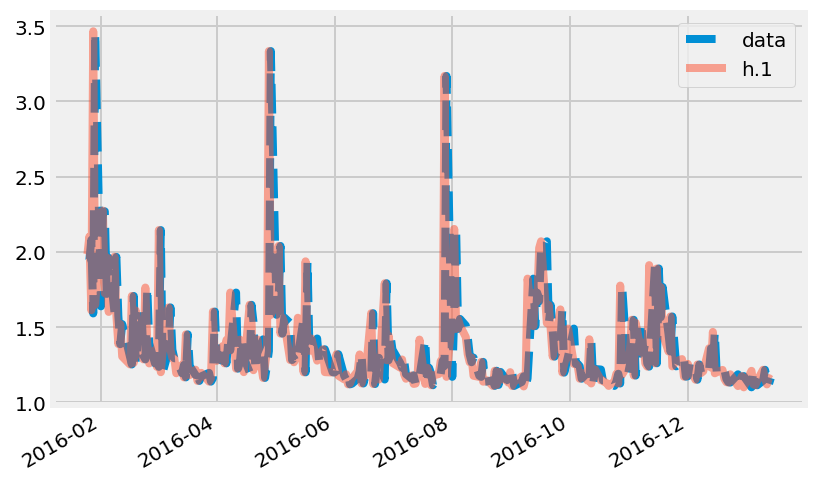

In [18]:
fig, ax = plt.subplots()
res.conditional_volatility.plot(ax=ax,label='data',ls='--')
forecasts.variance[['h.1']].apply(np.sqrt).plot(ax=ax,alpha=0.5)
ax.legend();

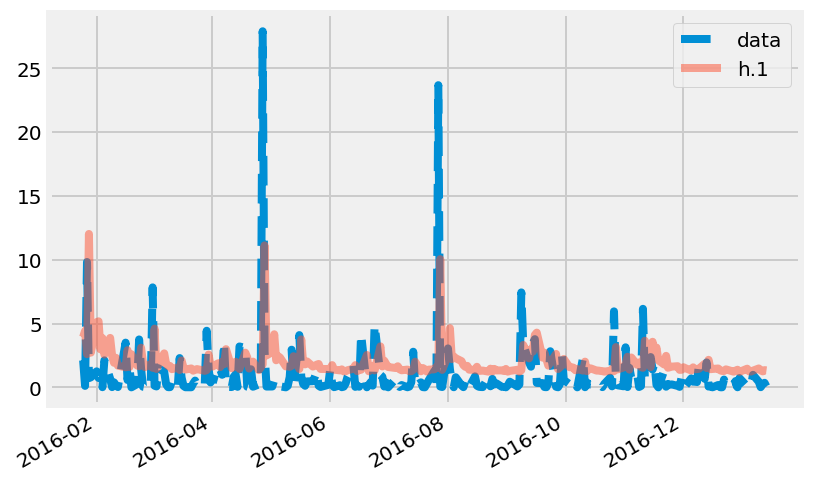

In [19]:
resid_all = (resid_standardized).map(np.square)

fig, ax = plt.subplots()
resid_all.plot(ax=ax,label='data',ls='--')
forecasts.residual_variance[['h.1']].plot(ax=ax,alpha=0.5)
ax.legend();

If the GARCH process is fit with constant mean, residual variance and variance will coincide.

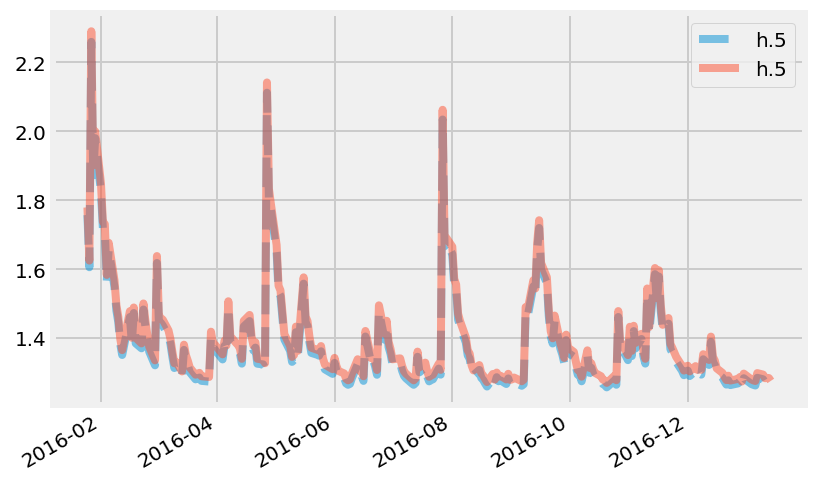

In [20]:
fig, ax = plt.subplots()
forecasts.residual_variance[['h.5']].apply(np.sqrt).plot(ax=ax,alpha=0.5,ls='--')
forecasts.variance[['h.5']].apply(np.sqrt).plot(ax=ax,alpha=0.5)
ax.legend();

## Predictions for mean and volatility

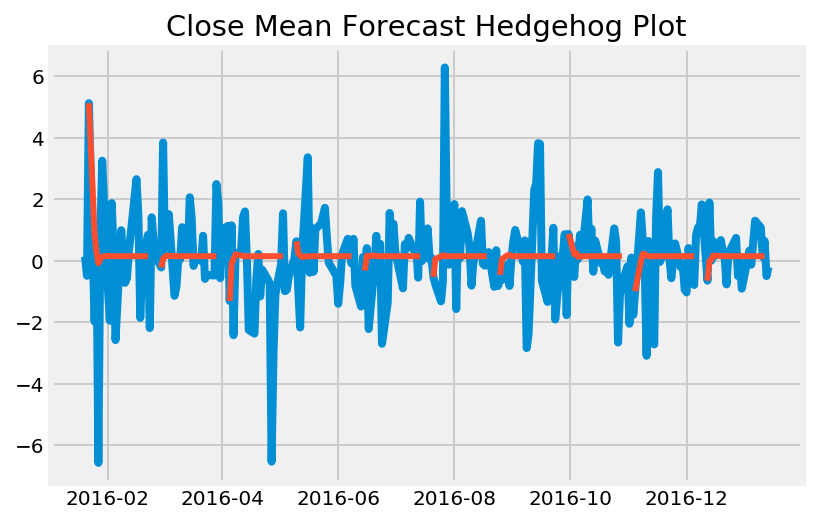

In [21]:
res.hedgehog_plot(horizon=20, step=25, type='mean');

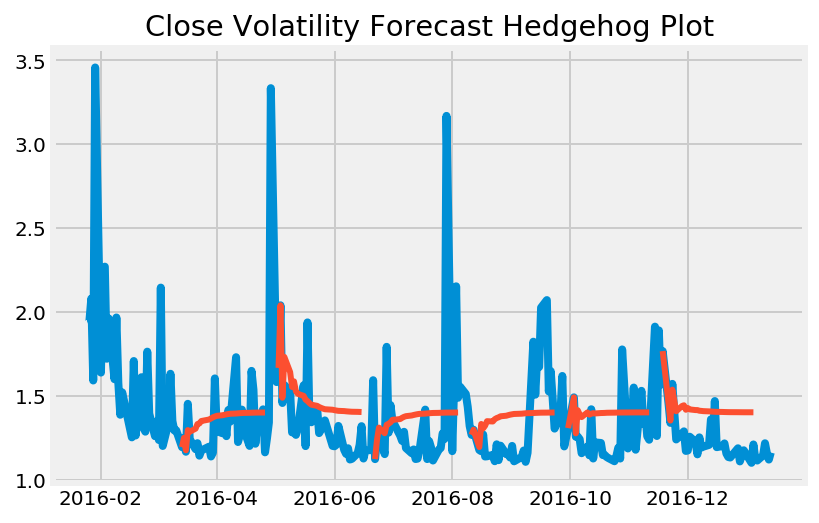

In [22]:
res.hedgehog_plot(horizon=30, step=35, type='volatility');

## Fitting with Exogenous Regressors

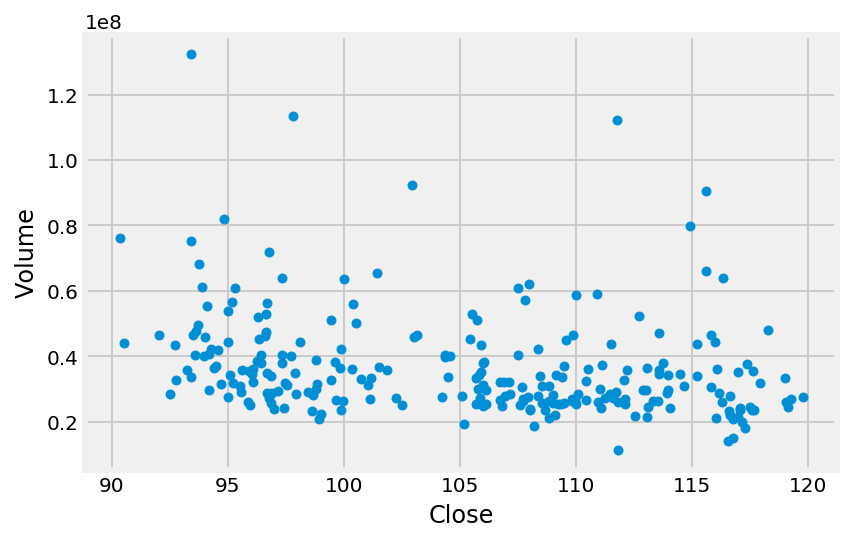

In [23]:
df.plot(kind='scatter',y='Volume',x='Close');

In [24]:
from arch.univariate import ARX

X = df[['Volume']][1:]
X = (X-X.mean())/X.std()
ar = ARX(data, X, lags = 3, constant=True)
ar.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    AR-X - Constant Variance Model Results                    
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.031
Mean Model:                      AR-X   Adj. R-squared:                  0.015
Vol Model:          Constant Variance   Log-Likelihood:               -431.196
Distribution:                  Normal   AIC:                           874.392
Method:            Maximum Likelihood   BIC:                           895.448
                                        No. Observations:                  247
Date:                Fri, Aug 24 2018   Df Residuals:                      241
Time:                        08:44:27   Df Model:                            6
                                 Mean Model                                
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
Const          0.0664  9.207e-02      0.721      0.471    [ -0.114,  0.247]
Close[1]       0.0964  6.858e-02      1.405      0.160 [-3.805e-02,  0.231]
Close[2]      -0.0217  7.724e-02     -0.281      0.779    [ -0.173,  0.130]
Close[3]      -0.0626  8.165e-02     -0.766      0.443  [ -0.223,9.746e-02]
Volume        -0.1835      0.235     -0.780      0.435    [ -0.645,  0.278]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
sigma2         1.9224      0.297      6.471  9.727e-11 [  1.340,  2.505]
========================================================================

Covariance estimator: White's Heteroskedasticity Consistent Estimator
"""

In [25]:
am = arch_model(data, x=X, mean='ARX', lags=3, vol='GARCH', p=3, q=3)
res = am.fit(update_freq=7)
res.summary()

Iteration:      7,   Func. Count:    108,   Neg. LLF: 423.91167961707185
Iteration:     14,   Func. Count:    213,   Neg. LLF: 421.87322610599324
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 421.81158534358804
            Iterations: 19
            Function evaluations: 284
            Gradient evaluations: 19


<class 'statsmodels.iolib.summary.Summary'>
"""
                          AR-X - GARCH Model Results                          
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.028
Mean Model:                      AR-X   Adj. R-squared:                  0.012
Vol Model:                      GARCH   Log-Likelihood:               -421.812
Distribution:                  Normal   AIC:                           867.623
Method:            Maximum Likelihood   BIC:                           909.736
                                        No. Observations:                  247
Date:                Fri, Aug 24 2018   Df Residuals:                      235
Time:                        08:44:28   Df Model:                           12
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
Const          0.1148      0.138      0.831      0.406   [ -0.156,  0.386]
Close[1]       0.1265      0.217      0.583      0.560   [ -0.299,  0.552]
Close[2]      -0.0192  9.243e-02     -0.208      0.835   [ -0.200,  0.162]
Close[3]      -0.0587  7.886e-02     -0.745      0.457 [ -0.213,9.585e-02]
Volume        -0.2245      0.321     -0.698      0.485   [ -0.854,  0.406]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.8542      0.623      1.371      0.170    [ -0.367,  2.075]
alpha[1]       0.0000      0.266      0.000      1.000    [ -0.521,  0.521]
alpha[2]       0.4108      0.457      0.899      0.369    [ -0.485,  1.307]
alpha[3]       0.0127      0.212  5.994e-02      0.952    [ -0.403,  0.428]
beta[1]        0.0000      0.493      0.000      1.000    [ -0.966,  0.966]
beta[2]        0.0888  9.954e-02      0.892      0.372    [ -0.106,  0.284]
beta[3]        0.1094  8.321e-02      1.315      0.189 [-5.367e-02,  0.272]
===========================================================================

Covariance estimator: robust
"""

## Conclusions

Finally we managed to address the stationary condition about constant variance which is often violated in particular by financial timeseries. We managed to do so by setting up an ARMA model for the conditional variance.

Additionally we saw how to incorporate exogenous regressors.